# Newsgroup20 Classification

In [1]:
import itertools
import scipy
import numpy as np
import pandas as pd
import logging

import helper
import gensim
from gensim.models import word2vec, doc2vec

import sklearn
from sklearn import metrics
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib
import matplotlib.pyplot as plt

import bokeh
from bokeh.plotting import figure, output_file, show

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
bokeh.plotting.output_notebook()

Loading BokehJS ...

### Available categories

In [4]:
with open('categories-ng20.txt') as f:
    all_categories = f.read().split()
', '.join(all_categories)

'comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, misc.forsale, talk.politics.misc, talk.politics.guns, talk.politics.mideast, talk.religion.misc, alt.atheism, soc.religion.christian'

### Fetch subset of newsgroup-20 dataset

In [5]:
REMOVE = ('headers', 'footers', 'quotes')
CATEGORIES = ('talk.politics.misc', 'comp.graphics', 'sci.space')
CATEGORIES = None

newsgroup_dataset_train = sklearn.datasets.fetch_20newsgroups(subset = 'train', remove = REMOVE, categories = CATEGORIES)
newsgroup_dataset_test = sklearn.datasets.fetch_20newsgroups(subset = 'test', remove = REMOVE, categories = CATEGORIES)

## Training classifiers on vectorized docs

### Feature extraction
Remove stopwords and vectorize with Tfidf

In [6]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english')
vectorizer.fit(newsgroup_dataset_train.data)

vectors_train = vectorizer.transform(newsgroup_dataset_train.data)
vectors_test = vectorizer.transform(newsgroup_dataset_test.data)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_transformer.fit(vectors_train)
vectors_trans_train = tfidf_transformer.transform(vectors_train)
vectors_trans_test = tfidf_transformer.transform(vectors_test)

### MostFrequentLabelClassifer
Always predicts the most-frequent label

In [7]:
df_train = pd.DataFrame(newsgroup_dataset_train.target)
df_train.rename(columns = {0: 'target'}, inplace = True)
most_frequent_class_in_train = round(df_train.target.mean())

class MostFrequentLabelClassifier(object):
     
    def __init__(self, label_to_return):
        self.label_to_return = label_to_return
        
    def fit(self, x = None, y = None):
        pass

    def predict(self, x = None):
        return [self.label_to_return] * x.shape[0]

### Train different classifiers on tfidf vectors of docs

MostFrequentLabel


/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


PassiveAggressiveClassifier
LogisticRegression
Perceptron
SGDClassifier


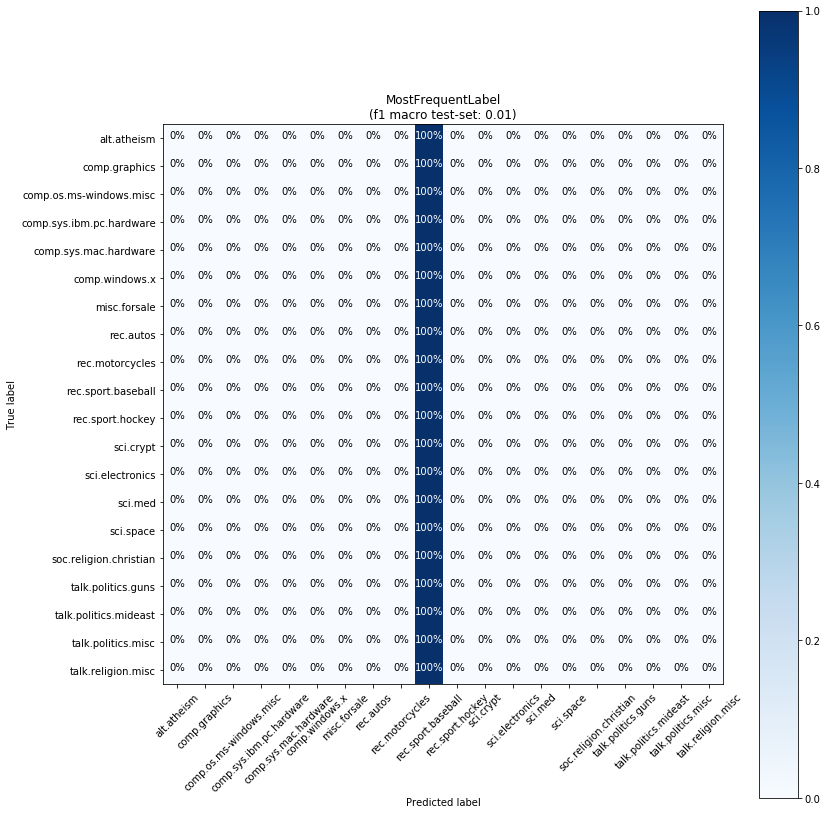

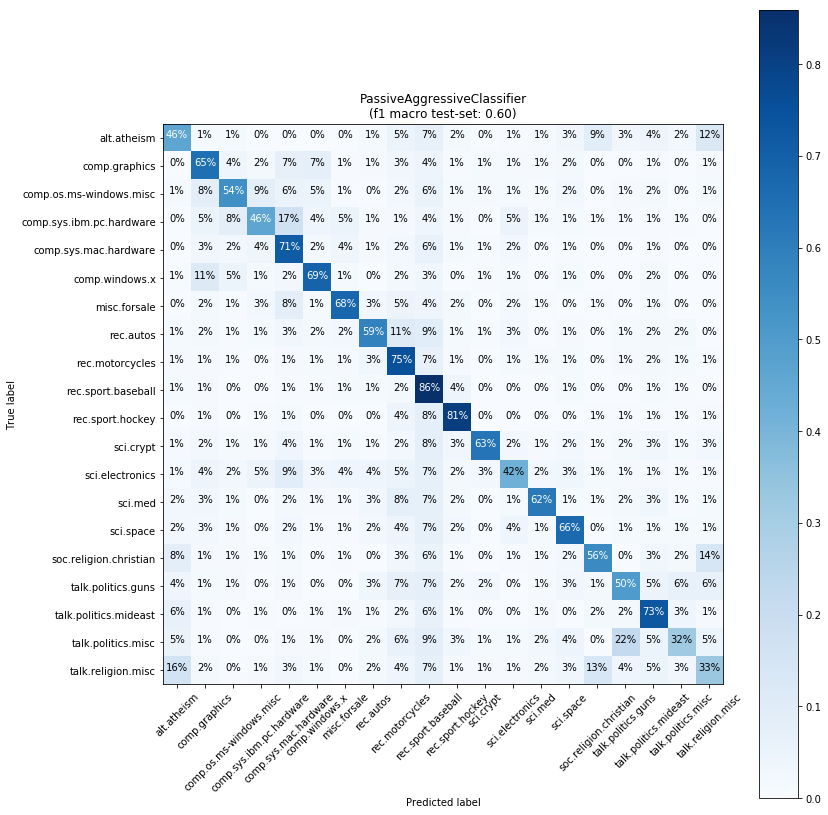

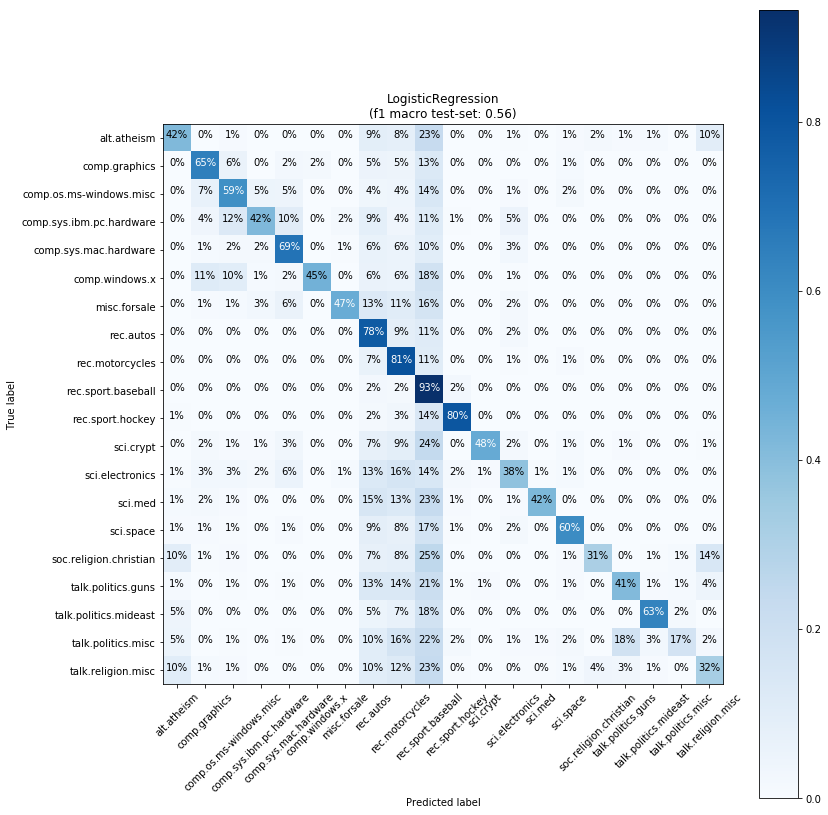

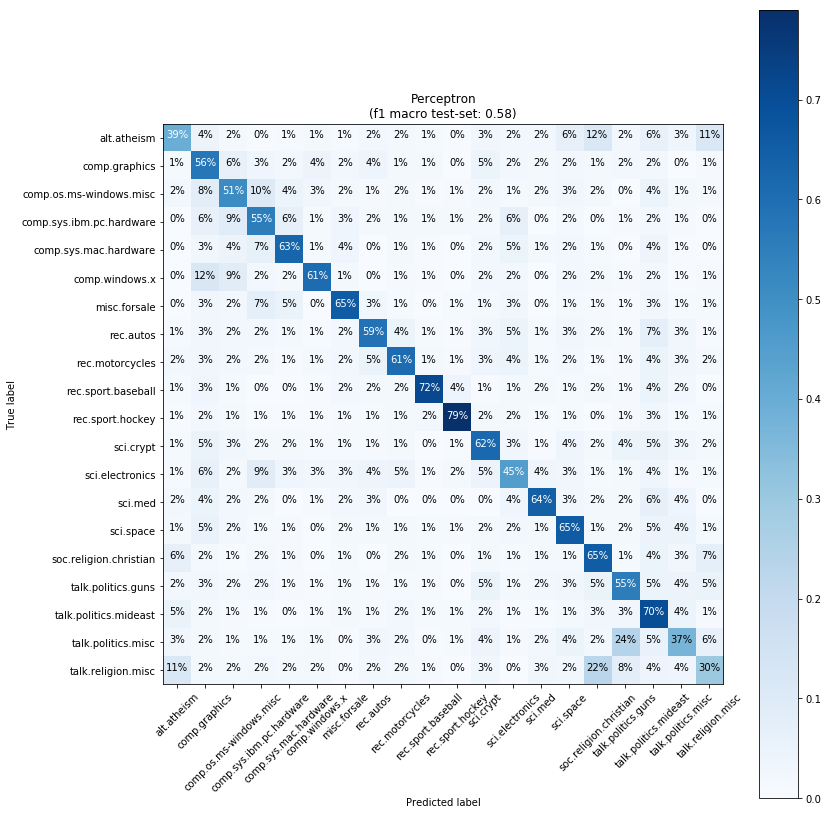

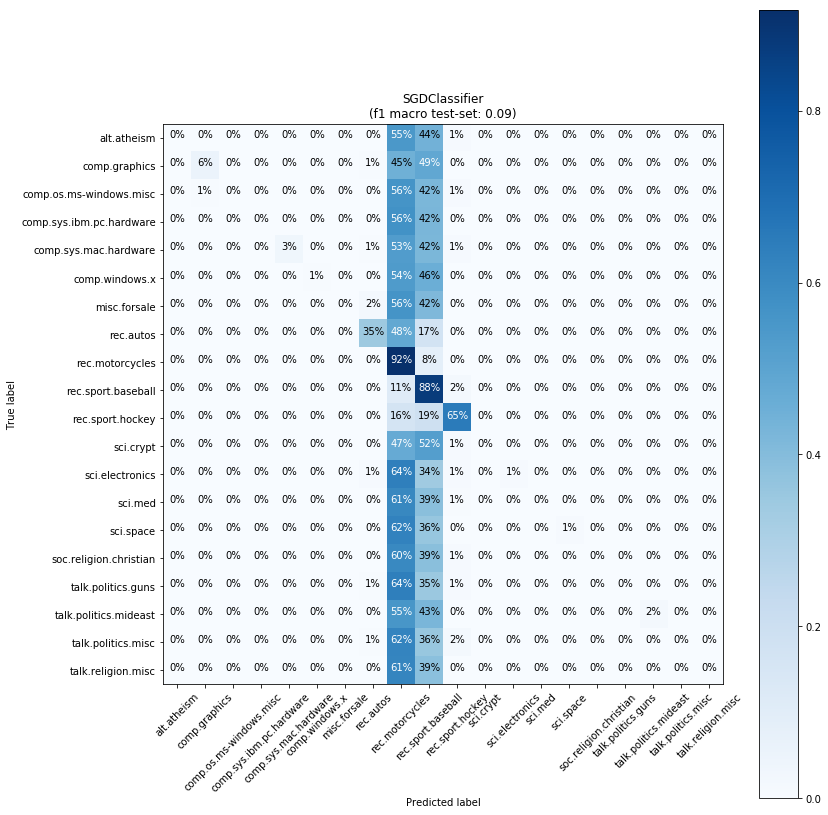

F1 Scores


,LogisticRegression,MostFrequentLabel,PassiveAggressiveClassifier,Perceptron,SGDClassifier
acc,0.546999,0.052708,0.609134,0.587361,0.154275
test,0.556416,0.005007,0.599012,0.579768,0.093522
train,0.952367,0.005012,0.971429,0.970395,0.150891


In [12]:
clfs = {
    'PassiveAggressiveClassifier': sklearn.linear_model.PassiveAggressiveClassifier(),
    'Perceptron': sklearn.linear_model.Perceptron(n_iter = 500),
    'LogisticRegression': sklearn.linear_model.LogisticRegression(max_iter = 500),
    'SGDClassifier': sklearn.linear_model.SGDClassifier(n_iter = 500),
    'MostFrequentLabel': MostFrequentLabelClassifier(most_frequent_class_in_train)
}

results = {}
for clf_name, clf in clfs.items():
    print(clf_name)
    clf.fit(vectors_train, newsgroup_dataset_train.target)
    pred_train = clf.predict(vectors_trans_train)
    pred_test = clf.predict(vectors_trans_test)
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test, 'acc': metrics.accuracy_score(newsgroup_dataset_test.target, pred_test)}
    confusion_matrix = metrics.confusion_matrix(newsgroup_dataset_test.target, pred_test)
    class_report = metrics.classification_report(newsgroup_dataset_test.target, pred_test, target_names=newsgroup_dataset_test.target_names)
    plt.figure(figsize = (12, 12))
    helper.plot_confusion_matrix(confusion_matrix, newsgroup_dataset_test.target_names, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)
plt.show()

print('F1 Scores')
pd.DataFrame(results)

## Train Doc2Vec and Word2Vec classifier

### Pre-process docs for d2v and w2v

In [13]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

def lemmatize(ambiguous_word, pos=None, neverstem=True, 
              lemmatizer=wnl, stemmer=porter):
    """Tries to convert a surface word into lemma, and if lemmatize word is not in
    wordnet then try and convert surface word into its stem.
    This is to handle the case where users input a surface word as an ambiguous 
    word and the surface word is a not a lemma.
    
    Adapted from https://github.com/alvations/pywsd/blob/master/pywsd/utils.py
    """
    if pos:
        lemma = lemmatizer.lemmatize(ambiguous_word, pos=pos)
    else:
        lemma = lemmatizer.lemmatize(ambiguous_word)
    stem = stemmer.stem(ambiguous_word)
    # Ensure that ambiguous word is a lemma.
    if not wn.synsets(lemma):
        if neverstem:
            return ambiguous_word
        if not wn.synsets(stem):
            return ambiguous_word
        else:
            return stem
    else:
        return lemma

LEMMATIZE = False
    
def w2v_preproess(doc):
    return [lemmatize(x.lower()) if LEMMATIZE else x.lower() for x in sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english').build_tokenizer()(doc)]

w2v_data = [w2v_preproess(doc) for doc in newsgroup_dataset_train.data]
w2v_data_test = [w2v_preproess(doc) for doc in newsgroup_dataset_test.data]

### Train Word2Vec

In [14]:
model_w2v = gensim.models.Word2Vec(w2v_data, iter = 50)

INFO : collecting all words and their counts
INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO : PROGRESS: at sentence #10000, processed 1937872 words, keeping 92659 word types
INFO : collected 101631 word types from a corpus of 2158589 raw words and 11314 sentences
INFO : Loading a fresh vocabulary
INFO : min_count=5 retains 22571 unique words (22% of original 101631, drops 79060)
INFO : min_count=5 leaves 2042885 word corpus (94% of original 2158589, drops 115704)
INFO : deleting the raw counts dictionary of 101631 items
INFO : sample=0.001 downsamples 42 most-common words
INFO : downsampling leaves estimated 1619590 word corpus (79.3% of prior 2042885)
INFO : estimated required memory for 22571 words and 100 dimensions: 29342300 bytes
INFO : resetting layer weights
INFO : training model with 3 workers on 22571 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO : PROGRESS: at 1.24% examples, 1025459 words/s, in_qsize 5, out_

### t-SNE vectors

In [15]:
# Ignore for now, very time-consuming
if 0 == 1:
    w2v_vectors = model_w2v[model_w2v.wv.vocab]

    tsne = sklearn.manifold.TSNE(n_components=2)
    tsne_vectors = tsne.fit_transform(w2v_vectors)

In [16]:
indexed_vocab = {v.index: k for k, v in model_w2v.wv.vocab.items()}
indexed_vocab_new = sorted([k for k in indexed_vocab.items()], key = lambda x:x[0])
indexed_vocab_new = [x[1] for x in indexed_vocab_new]

def plot_embedding_plt(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(50, 50), dpi=300)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(indexed_vocab[i]),
                 fontdict={'size': 20})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

def plot_embedding_bokeh(X, width = 1000, height = 1000):
    from bokeh.models import HoverTool
    hover = HoverTool(tooltips = [
            ('Word', '@target'),
            ('index', '$index')
    ])
    
    p = bokeh.plotting.figure(plot_width=width, plot_height=height, tools = [hover, bokeh.models.WheelZoomTool(), bokeh.models.PanTool()])
    df = pd.DataFrame(X, columns=['x', 'y'])
    df['target'] = pd.Series(indexed_vocab_new, index=df.index)

    source = bokeh.plotting.ColumnDataSource(df)
    p.circle(x = df.x, y = df.y, source = source, size=20, color="navy", alpha=0.5)
    return p


if 0 == 1:
    show(plot_embedding_bokeh(tsne_vectors, width = 900, height = 700))
    
    plot_embedding_plt(tsne_vectors)
    plt.savefig('yes.png')


### Train Doc2Vec

In [17]:
tagged_documents = [gensim.models.doc2vec.TaggedDocument(words = words, tags = [tags]) for words, tags in zip(w2v_data, newsgroup_dataset_train.target)]
model_d2v = gensim.models.Doc2Vec(tagged_documents, size = 1000, iter = 50)

INFO : collecting all words and their counts
INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO : PROGRESS: at example #10000, processed 1937872 words (4263249/s), 92659 word types, 20 tags
INFO : collected 101631 word types and 20 unique tags from a corpus of 11314 examples and 2158589 words
INFO : Loading a fresh vocabulary
INFO : min_count=5 retains 22571 unique words (22% of original 101631, drops 79060)
INFO : min_count=5 leaves 2042885 word corpus (94% of original 2158589, drops 115704)
INFO : deleting the raw counts dictionary of 101631 items
INFO : sample=0.001 downsamples 42 most-common words
INFO : downsampling leaves estimated 1619590 word corpus (79.3% of prior 2042885)
INFO : estimated required memory for 22571 words and 1000 dimensions: 191933500 bytes
INFO : resetting layer weights
INFO : training model with 3 workers on 22571 vocabulary and 1000 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO : PROGRESS: at 0.27% examples,

INFO : PROGRESS: at 27.24% examples, 226575 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 27.47% examples, 226193 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 27.74% examples, 225909 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 28.01% examples, 225610 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 28.28% examples, 225513 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 28.60% examples, 225633 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 28.87% examples, 225887 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 29.19% examples, 226050 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 29.47% examples, 226112 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 29.77% examples, 226190 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 30.12% examples, 226436 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 30.42% examples, 226551 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 30.70% examples, 226684 words/s, in_qsize 5, out_qsize 0

INFO : PROGRESS: at 60.10% examples, 236327 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 60.42% examples, 236425 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 60.71% examples, 236509 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 61.01% examples, 236586 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 61.33% examples, 236673 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 61.67% examples, 236826 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 62.01% examples, 236937 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 62.33% examples, 237024 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 62.64% examples, 237068 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 62.91% examples, 237077 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 63.19% examples, 237014 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 63.51% examples, 237084 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 63.85% examples, 237226 words/s, in_qsize 6, out_qsize 0

INFO : PROGRESS: at 93.29% examples, 240498 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 93.63% examples, 240539 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 93.97% examples, 240550 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 94.28% examples, 240592 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 94.61% examples, 240622 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 94.89% examples, 240689 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 95.22% examples, 240740 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 95.54% examples, 240778 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 95.87% examples, 240842 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 96.23% examples, 240888 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 96.57% examples, 240956 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 96.83% examples, 241018 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 97.17% examples, 241072 words/s, in_qsize 5, out_qsize 0

#### Scores for Doc2Vec (f1 macro, confusion matrix, classification report)

In [18]:
d2v_inferred_train = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data]
d2v_inferred_test = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data_test]

def fit_and_predict_d2v(clf):
    """Fit the given classifier to the train/test data.
    Return predictions.
    """
    clf.fit(model_d2v.docvecs, list(range(len(model_d2v.docvecs))))
    pred_train = clf.predict(np.array(d2v_inferred_train))
    pred_test = clf.predict(np.array(d2v_inferred_test))
    return pred_train, pred_test

In [19]:
d2v_classification_predictions = {clf_name: fit_and_predict_d2v(clf) for clf_name, clf in clfs.items()}

In [22]:
results = {}
for clf_name, predictions in d2v_classification_predictions.items():
    pred_train, pred_test = predictions[0], predictions[1]
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    confusion_matrix = metrics.confusion_matrix(newsgroup_dataset_test.target, pred_test)
    class_report = metrics.classification_report(newsgroup_dataset_test.target, pred_test, target_names=newsgroup_dataset_test.target_names)
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test}
    plt.figure(figsize = (12, 12))
    helper.plot_confusion_matrix(confusion_matrix, newsgroup_dataset_test.target_names, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)

/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


### Results doc2vec classifier

/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


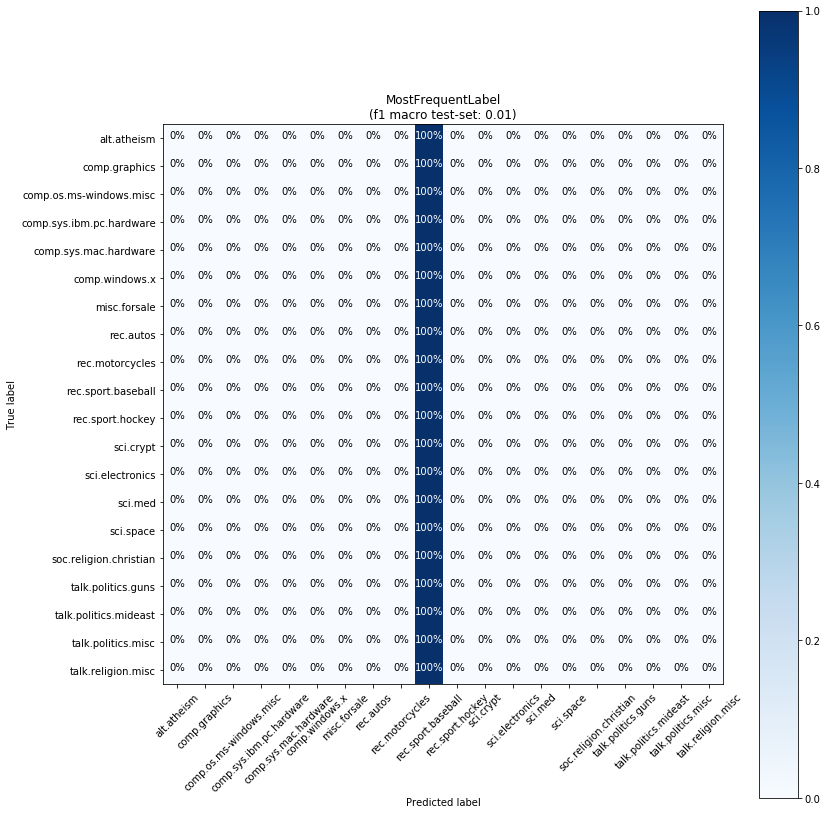

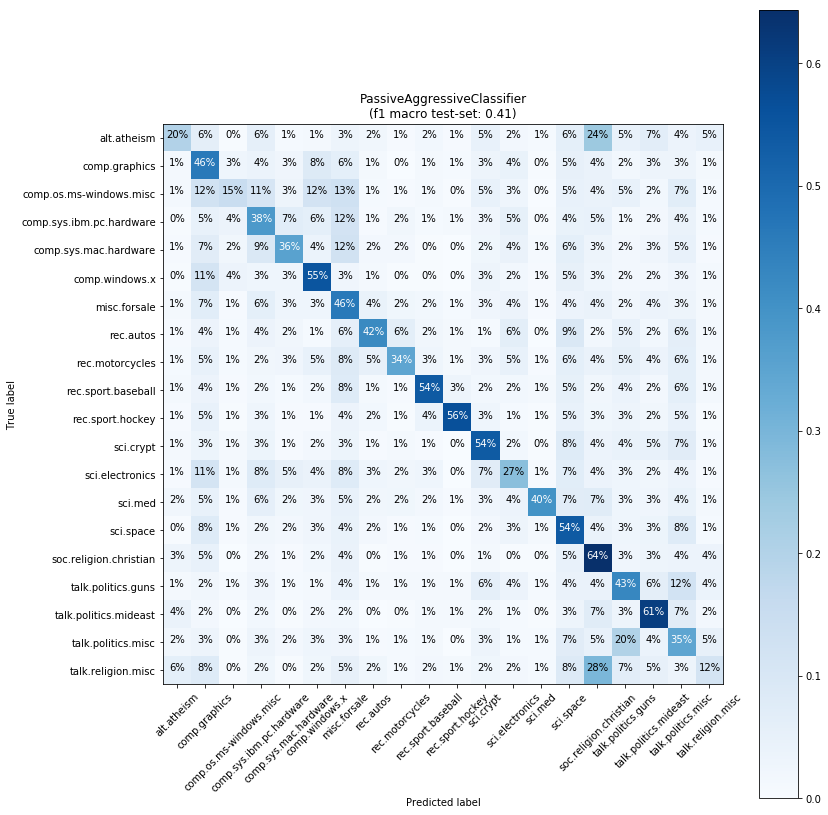

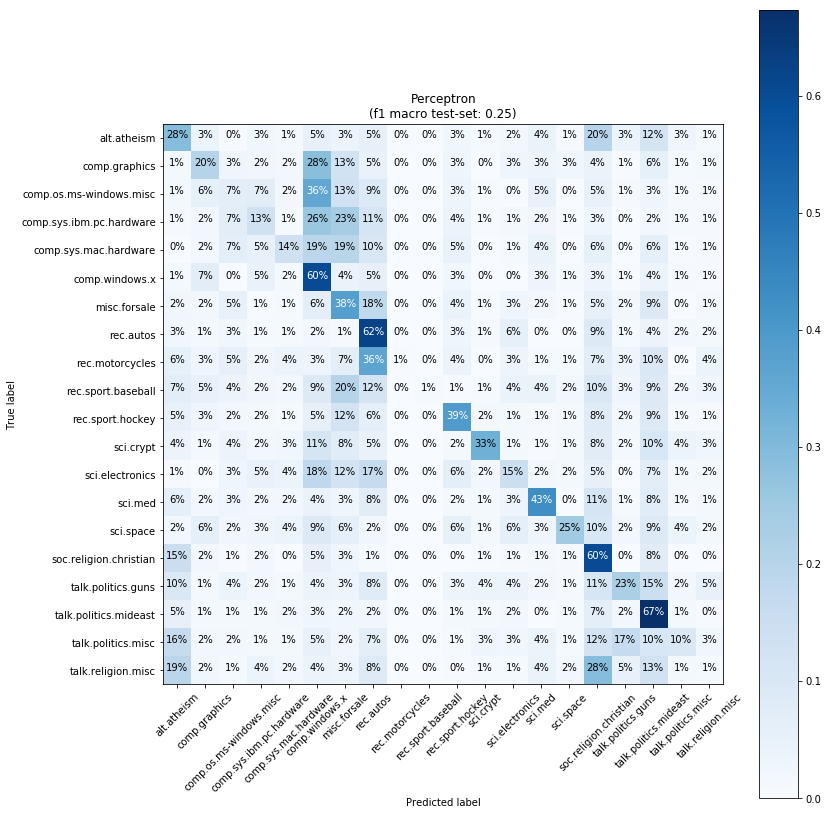

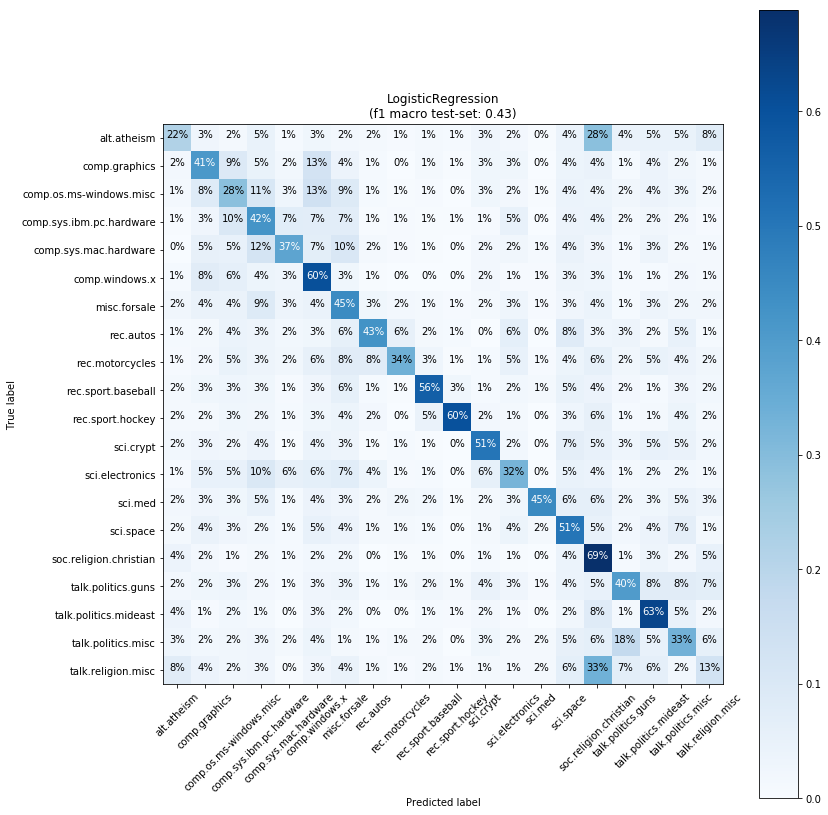

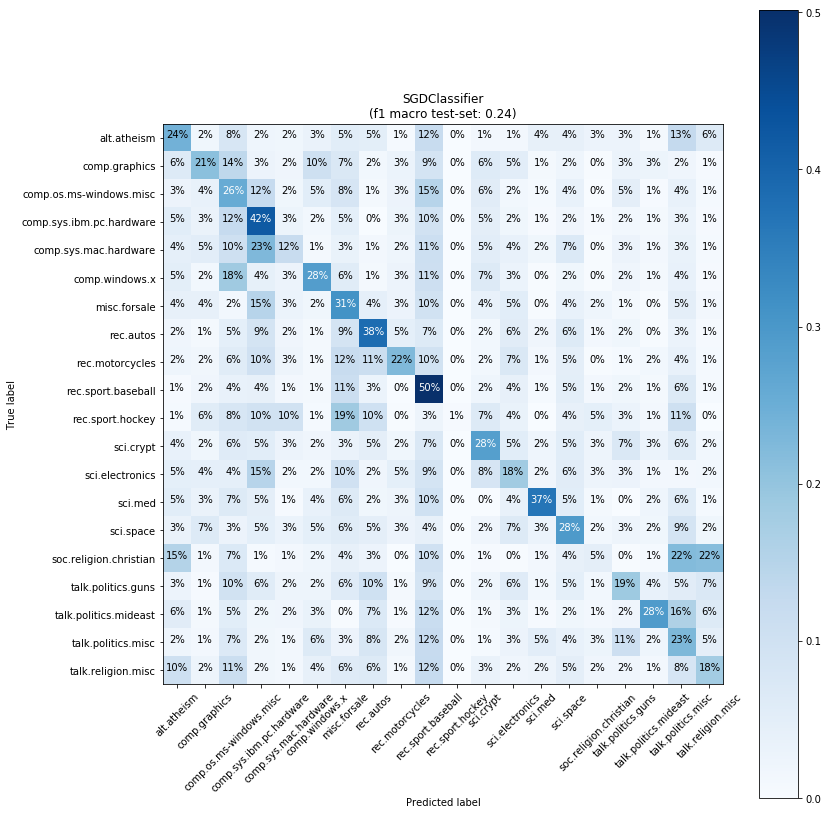

,LogisticRegression,MostFrequentLabel,PassiveAggressiveClassifier,Perceptron,SGDClassifier
test,0.434895,0.005007,0.414886,0.24897,0.242676
train,0.447262,0.005012,0.416399,0.26531,0.260234


In [23]:
plt.show()
pd.DataFrame(results)